In this analysis, we will focus on the previously selected 31 features. We will investigate the relationships among these features, use dimension-reduction techniques (e.g., PCA) to predict diabetes, and conduct t-test to compare diabetes rate between subgroups (e.g., metro vs. nonmetro counties). Specifically, we will analyze:
 - Coorelation heatmap among the features
 - PCA
 - t-test between metro and non-metrao counties
 - t-test between persistent poverty and non-poverty counties

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import t
from scipy.stats import norm
#from pandas.plotting import scatter_matrix 

%matplotlib inline

In [2]:
# Getting data
# health = pd.read_excel("atlas.xlsx", sheet_name= "HEALTH")
# socio = pd.read_excel("atlas.xlsx", sheet_name= "SOCIOECONOMIC")
# access = pd.read_excel('atlas.xlsx', sheet_name="ACCESS")
# restaurants = pd.read_excel('atlas.xlsx', sheet_name='RESTAURANTS')
# insecurity = pd.read_excel('atlas.xlsx', sheet_name='INSECURITY')
# price = pd.read_excel('atlas.xlsx', sheet_name="PRICES_TAXES")
# local = pd.read_excel('atlas.xlsx', sheet_name="LOCAL")

# health = health.set_index('FIPS')
# socio = socio.set_index('FIPS')
# access = access.set_index('FIPS')
# restaurants = restaurants.set_index('FIPS')
# insecurity = insecurity.set_index('FIPS')
# price = price.set_index('FIPS')
# local = local.set_index('FIPS')


In [3]:
# stores = pd.read_excel('atlas.xlsx', sheet_name="STORES")
# assistance = pd.read_excel('atlas.xlsx', sheet_name="ASSISTANCE")
# stores = stores.set_index('FIPS')
# assistance = assistance.set_index('FIPS')

In [4]:
# Concatenate data into one dataframe
# df = pd.concat([health,socio,access,restaurants,insecurity, price,local,stores,assistance], axis=1)

In [5]:
df = pd.read_csv('data_atlas/atlas.csv')

In [6]:
df.shape

(3143, 280)

In [7]:
#df.to_csv('atlas.csv')

In [8]:
df.head()

,FIPS,State,County,PCT_DIABETES_ADULTS08,PCT_DIABETES_ADULTS13,PCT_OBESE_ADULTS08,PCT_OBESE_ADULTS13,PCT_HSPA15,RECFAC09,RECFAC14,...,REDEMP_WICS08,REDEMP_WICS12,PCH_REDEMP_WICS_08_12,PCT_WIC09,PCT_WIC15,PCH_WIC_09_15,PCT_CACFP09,PCT_CACFP15,PCH_CACFP_09_15,FDPIR12
0,1001,AL,Autauga,11.4,13.0,31.5,34.1,25.4,4,5,...,161658.70,184744.3,14.280490,2.990417,2.719352,-0.271065,0.91609,1.055597,0.139507,0
1,1003,AL,Baldwin,9.8,10.4,26.2,27.4,25.4,18,25,...,125840.50,126639.4,0.634881,2.990417,2.719352,-0.271065,0.91609,1.055597,0.139507,0
2,1005,AL,Barbour,13.6,18.4,37.6,44.4,25.4,1,0,...,178230.60,157077.1,-11.868620,2.990417,2.719352,-0.271065,0.91609,1.055597,0.139507,0
3,1007,AL,Bibb,11.1,14.8,32.3,40.3,25.4,1,1,...,92542.33,98263.4,6.182112,2.990417,2.719352,-0.271065,0.91609,1.055597,0.139507,0
4,1009,AL,Blount,11.4,14.1,31.9,34.6,25.4,3,3,...,102945.90,149110.0,44.843050,2.990417,2.719352,-0.271065,0.91609,1.055597,0.139507,0


In [11]:
# Getting the 31 shortlist features
features = pd.read_csv('data_atlas/features_shortlist.csv')

# Dataframe with only 31 features plus diabetes rate
df2 = pd.read_csv('data_atlas/counties_features.csv')

In [ ]:
df2.head()

## 1. Correlation heatmap

In [ ]:
# Make correlation matrix
# Remove state, county (categorical) and obesity (because it is health data and correlated with diabites)

# Note this is based on counties data. In previous analysis state averages were used.
corr =df2.iloc[:,2:-1].corr() # Remove state, county (categorical) and obesity (because it is health data and correlated with diabites)


plt.figure(figsize=(12,12))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20,220,n=200),
    square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

plt.show()

In [ ]:
corr

## 2. Check missing values and outliers

In [ ]:
# Use state average for PCA analysis

# First calculate state average and fill nan with national average

df2 = pd.read_csv('data_atlas/counties_features.csv')
state_avg = df2.groupby('State',as_index=False).mean()

In [ ]:
state_avg.head()

In [ ]:
# Replace states that has no values with national average 
state_avg.fillna(state_avg.mean(), inplace=True)

In [ ]:
# Double check after replace nan 
state_avg.isnull().sum().sum()

In [ ]:
# Check for outliners

# For loop to find outliers and convert them to NaN
outliers = {}

for column in state_avg.iloc[:,1:]: # remove 'States' column
    data = state_avg[column]
    mean = data.mean()
    std = data.std()
    
    # Define outliers and find their indexes
    outlier = data[(data > (mean+3*std))|(data < (mean-3*std))] # Alternatively: low,high = np.percentile(data,[1,99])
    slice_index = outlier.index # 
    
    
    # If there is no outlier in this column, go back to the beginning of the loop
    if slice_index.shape[0] == 0: continue   
    
    # Append outliers in a dictionary
    outliers[column]=state_avg[column].loc[slice_index]
    
    #print(df[[column]].loc[slice_index],df[column].mean())
    
    # Can Convert outliers into NaN in df if needed:
    
    #data[(data > (mean+3*std))|(data < (mean-3*std))] = np.NaN
    

In [ ]:
#state_avg.to_csv('stateaverages.csv')

In [ ]:
state_avg.describe()

In [ ]:
means = pd.DataFrame(state_avg.mean())
means.columns = ['National_average']

In [ ]:
# State average outliers
# df_outliers = pd.DataFrame(outliers.values())
# df_outliers.columns = state_avg.iloc[df_outliers.columns.tolist(),0].tolist() # Change column names and add state mean values
# df_outliers = df_outliers.join(means,how='left')
# df_outliers = df_outliers.join(features.set_index('VarCode')['VarName'],how='left') # Add variable name 
# df_outliers

In [ ]:
# Check missing values
df2.isnull().sum()

In [ ]:
df2.head()

In [ ]:
# Replace missing values with State averages

for column in df2.columns[3:]:

    df_null = df2.loc[df2[column].isnull(),['State',column]] # Subset df2 with only null rows and two columns: state and one feature
    column_name = df_null.columns[1] #feature name
    
    nans =  df_null[column].tolist()  # Create a list of nans 
    avg = [] # Create an empty list for state average values to be replaced 
    
    for row in range(df_null.shape[0]):
        state = df_null['State'].tolist()[row] # Get name of state to which the county with null value belongs
        
        # find mean value from the state_avg dataframe, append to avg
        avg.append(state_avg.loc[state_avg['State']== state,column_name].values[0]) 

    # Replace the nans for each column in df2
    df2[column].replace(to_replace=nans, value=avg, inplace=True)



In [ ]:
# Confirm no missing values
df2.isnull().sum().sum()

In [ ]:
df2.head()

In [ ]:
# Check for outliners for county data using the 3*sd method

# For loop to find outliers and convert them to NaN
county_outliers = {}

for column in df2.iloc[:,3:]: # remove 'FIPS','State', 'County' column
    data = df2[column]
    mean = data.mean()
    std = data.std()
    
    # Define outliers and find their indexes
    outlier = data[(data > (mean+3*std))|(data < (mean-3*std))] # Alternatively: low,high = np.percentile(data,[1,99])
    slice_index = outlier.index # 
    
    
    # If there is no outlier in this column, go back to the beginning of the loop
    if slice_index.shape[0] == 0: continue   
    
    # Append outliers in a dictionary
    county_outliers[column]=df2[column].loc[slice_index]
    
    #print(df[[column]].loc[slice_index],df[column].mean())
    
    # Can Convert outliers into NaN in df if needed:
    
    #data[(data > (mean+3*std))|(data < (mean-3*std))] = np.NaN
    

In [ ]:
#county_outliers

In [ ]:
# Winsorization of outliers 
from scipy.stats.mstats import winsorize

df_winsorized = df2.copy()
for column in df_winsorized.iloc[:,3:]:
    df_winsorized[column]=winsorize(df_winsorized[column],limits=[0.05,0.05])


In [ ]:
df_winsorized.shape

In [ ]:
df_winsorized.to_csv('data_atlas/counties_features_cleaned.csv')

Removed outliers via winsorization. 
Tried winsorized data on PCA and t-test analyses. 
However, PCA results (% variance explained is lower than using stage average, so state average data is kept).
Using winsorized data on the t-test might not be necessary and the distribution of data become less normal than before. Therefore, the original county data were used for the t-test.

## 3. PCA analysis

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,QuantileTransformer

scaler = QuantileTransformer()


data_scaled = scaler.fit_transform(state_avg.iloc[:,2:-1]) # remove state, county, diabetes (dependent var) and obesity (correlated health var)

# Tried winsorized county-level data. Results not as good as state data
#data_scaled = scaler.fit_transform(df_winsorized.iloc[:,3:]) 

pca = PCA(n_components=10)

pca_features = pca.fit_transform(data_scaled)


In [ ]:
data_scaled.shape

In [ ]:
pca_features.shape

In [ ]:
tally = 0
scree = [0]
for percent in pca.explained_variance_ratio_:
    tally+=percent
    scree.append(tally)
    
plt.figure(figsize=(5,5))
plt.plot(scree)
plt.xlabel('Number of Principal Components')
plt.ylabel('Fraction Variance Explained')
plt.ylim(0,1)

print(scree[1]) # first component explained 42% variance
print(scree[2]) # first 2 components explained 59% variance
print(scree[3]) # first 3 components explained 66% variance

In [ ]:
# Visualize PC1 loadings
y_range = list(range(1,len(state_avg.columns[2:-1])+1))

fig, ax = plt.subplots(figsize=(8,10))
plt.hlines(y=y_range, xmin=0,xmax=pca.components_[0],linewidth=5)

ax.set_xlabel('PC1')
#ax.tick_params(axis='both',which='major',labelsize=12)
plt.yticks(y_range,features['VarName'][0:-1],fontsize=12)

plt.show()


In [ ]:
# Visualize PC2 loadings
y_range = list(range(1,len(state_avg.columns[2:-1])+1))

fig, ax = plt.subplots(figsize=(8,10))
plt.hlines(y=y_range, xmin=0,xmax=pca.components_[1],linewidth=5)

ax.set_xlabel('PC2')
#ax.tick_params(axis='both',which='major',labelsize=12)
plt.yticks(y_range,features['VarName'][0:-1],fontsize=12)

plt.show()

In [ ]:
# Plot PC1 values against diabetes rates across the states

sns.regplot(x=pca_features[:,0],y=state_avg.PCT_DIABETES_ADULTS13)
plt.xlabel('PC1')
 
# corr = 0. 75

## 4. t-test between subgroups 
### Metro vs. non-metro
### Persistent poverty vs. non-poverty

In [13]:
socio = pd.read_excel("atlas.xlsx", sheet_name= "SOCIOECONOMIC")
socio = socio.set_index('FIPS')
metro = pd.DataFrame(socio['METRO13'])

In [14]:
metro = metro.reset_index()

In [15]:
metro.head()

,FIPS,METRO13
0,1001,1
1,1003,1
2,1005,0
3,1007,1
4,1009,1


In [16]:
df3 = pd.concat([df2,metro['METRO13']],axis=1) # Add metro data to dataframe

# Tried winsorized data, the data distribution is less normal (when plotting the histgram) so did not end up using winsorized data for analyses. 
# df3 = pd.concat([df_winsorized,metro],axis=1)

In [17]:
df3.head()

,FIPS,State,County,PCT_DIABETES_ADULTS13,FSRPTH09,MEDHHINC15,PC_DIRSALES12,RECFACPTH09,SPECSPTH09,SODA_PRICE10,...,PCT_SNAP12,PCT_FREE_LUNCH09,PERPOV10,SUPERCPTH09,PCT_SBP09,SNAPSPTH12,POVRATE15,PCT_LACCESS_HHNV10,PCT_OBESE_ADULTS13,METRO13
0,1001,AL,Autauga,13.0,0.628059,56580.0,5.582238,0.073889,0.036945,0.972216,...,18.824675,32.006749,0,0.018472,4.509008,0.674004,12.7,3.284786,34.1,1
1,1003,AL,Baldwin,10.4,1.125938,52387.0,3.403433,0.100331,0.117053,1.001391,...,18.824675,33.216055,0,0.033444,4.509008,0.725055,12.9,2.147827,27.4,1
2,1005,AL,Barbour,18.4,0.433887,31433.0,0.478663,0.036157,0.072314,0.992584,...,18.824675,68.245839,1,0.000000,4.509008,1.280590,32.0,4.135869,44.4,0
3,1007,AL,Bibb,14.8,0.261540,40767.0,0.883314,0.043590,0.000000,0.972216,...,18.824675,50.278552,0,0.043590,4.509008,0.719122,22.2,3.458580,40.3,1
4,1009,AL,Blount,14.1,0.331351,50487.0,8.567571,0.052319,0.034879,0.972216,...,18.824675,39.681098,0,0.017440,4.509008,0.657144,14.7,3.269380,34.6,1


In [18]:
# Diabete rates in Metro and non-metro counties 

diabetes_metro = df3.loc[df3['METRO13']== 1,:]
diabetes_nonmetro = df3.loc[df3['METRO13']== 0,:]
print('There are {} metro and {} non-metro counties.'.format(diabetes_metro.shape[0],diabetes_nonmetro.shape[0]))

There are 1167 metro and 1976 non-metro counties.


### Are there differences in diabete rates between the means of metro and nonmetro counties

Null hypothesis: No, there is not.
Hypothesis: Yes, there is difference in diabete rate between metro and non-metro counties.

In [19]:
# Mean and population SD

x1 = np.mean(diabetes_metro['PCT_DIABETES_ADULTS13'])
x0 = np.mean(diabetes_nonmetro['PCT_DIABETES_ADULTS13'])

s1 = np.std(diabetes_metro['PCT_DIABETES_ADULTS13'], ddof=1)
s0 = np.std(diabetes_nonmetro['PCT_DIABETES_ADULTS13'],ddof=1)

n1 = diabetes_metro.shape[0]
n0 = diabetes_nonmetro.shape[0]
print('Metro','Non-Metro','\n',x1,x0,'\n',s1,s0,'\n',n1,n0)


Metro Non-Metro 
 10.770926243567759 11.51062753036438 
 2.345589304259139 2.5252102879584704 
 1167 1976


In [20]:
# 95% confidence interval of the mean using t distribution
tvalue= t.ppf(0.95,n1-1)

CI_upper1 = x1 + tvalue*s1/np.sqrt(n1)
CI_lower1 = x1 - tvalue*s1/np.sqrt(n1)

CI_upper0 = x0 + tvalue*s0/np.sqrt(n0)
CI_lower0 = x0 - tvalue*s0/np.sqrt(n0)
print('t value',tvalue, '\n',
      "Metro CI:",CI_lower1,CI_upper1,'\n',
     "Non-Metro CI",CI_lower0,CI_upper0 )

t value 1.6461615067831432 
 Metro CI: 10.657897477438556 10.883955009696962 
 Non-Metro CI 11.41711355449565 11.604141506233109


/Users/Sabrina/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Sabrina/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


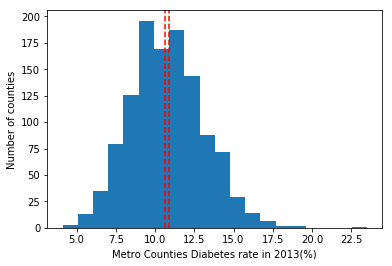

In [21]:
# Plot distribution of diabetes rates 
plt.hist(diabetes_metro['PCT_DIABETES_ADULTS13'],bins=20)
plt.xlabel('Metro Counties Diabetes rate in 2013(%)')
plt.ylabel('Number of counties')
plt.axvline(10.66,color='r',linestyle='--')
plt.axvline(10.88,color='r',linestyle='--')
plt.show()

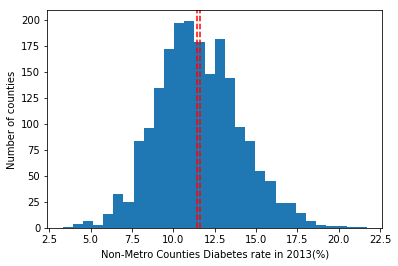

In [22]:
plt.hist(diabetes_nonmetro['PCT_DIABETES_ADULTS13'], bins=30)
plt.xlabel('Non-Metro Counties Diabetes rate in 2013(%)')
plt.ylabel('Number of counties')
plt.axvline(11.42,color='r',linestyle='--')
plt.axvline(11.60,color='r',linestyle='--')
plt.show()

Text(0, 0.5, 'Diabetes Rate (%)')

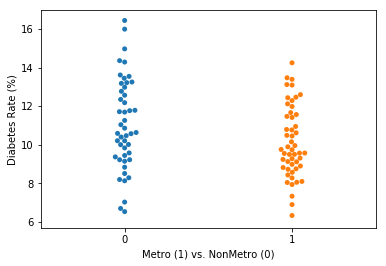

In [23]:
# Swarm plot by state means
sns.swarmplot(x='METRO13', y='PCT_DIABETES_ADULTS13', data=df3.groupby(['State','METRO13']).mean().reset_index())
plt.xlabel('Metro (1) vs. NonMetro (0)')
plt.ylabel('Diabetes Rate (%)')

In [24]:
# Empirical cumulative distribution function (ECDF)

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements"""
    n =len(data)
    x = np.sort(data)
    y = np.arange(1,n+1)/n
    return x,y


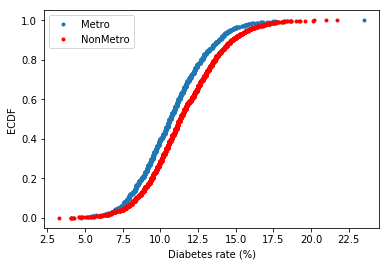

In [25]:
# Plot ECDF for metro and nonmetro counties

x_metro, y_metro = ecdf(diabetes_metro['PCT_DIABETES_ADULTS13'])
x_nonmetro, y_nonmetro = ecdf(diabetes_nonmetro['PCT_DIABETES_ADULTS13'])

plt.plot(x_metro,y_metro,marker='.',linestyle='none',label='Metro')
plt.plot(x_nonmetro,y_nonmetro,marker='.',linestyle='none', color = 'red',label='NonMetro')
plt.xlabel('Diabetes rate (%)')
plt.ylabel('ECDF')
plt.legend()
plt.show()

In [26]:
# Calculate pooled standard deviation and t statistic
sp = np.sqrt(((n0-1)*s1**2+(n1-1)*s0**2)/(n0+n1-2))
tp = (x0-x1)/(sp*np.sqrt(1/n0+1/n1))
print(sp,tp)

2.4138285332999234 8.300546085662871


In [27]:
dfreedom = n1+n0-2
p1 = 1 - t.cdf(abs(tp),dfreedom)
print(round(p1,2))

0.0


In [28]:
# Alternatively we can use stats.ttest_ind 
t1,p1 = stats.ttest_ind(diabetes_metro['PCT_DIABETES_ADULTS13'],diabetes_nonmetro['PCT_DIABETES_ADULTS13'],
                        nan_policy='omit')
print('p value:',round(p1,2))

p value: 0.0


### Because p=0, we can reject our null hypothesis and conclude that there is significant differences in diabetes rate between metro and non-metro counties. 
### Non-metro counties has higher diabetes rate. 

### How about between persistant-poverty counties and non-poverty counties? (feature code PERPOV10)

#### Null hypothesis: There is no difference in diabetes rate between them
#### Hypothesis: Yes, there is. 

In [29]:
ppov = df3.loc[df3['PERPOV10']== 1,:]
non_ppov = df3.loc[df3['PERPOV10']== 0,:]
print('There are {} ppov and {} non-ppov counties.'.format(ppov.shape[0],non_ppov.shape[0]))

There are 353 ppov and 2790 non-ppov counties.


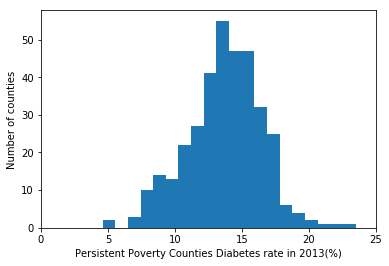

In [30]:
# Visualize the two groups
 
plt.hist(ppov['PCT_DIABETES_ADULTS13'], bins=20)
plt.xlabel('Persistent Poverty Counties Diabetes rate in 2013(%)')
plt.xlim(0,25)
plt.ylabel('Number of counties')
plt.show()

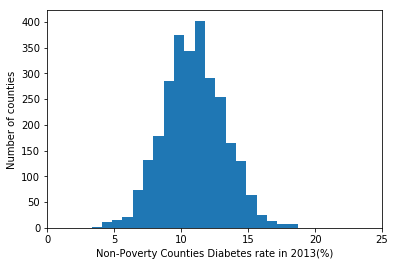

In [31]:
plt.hist(non_ppov['PCT_DIABETES_ADULTS13'], bins=20)
plt.xlabel('Non-Poverty Counties Diabetes rate in 2013(%)')
plt.ylabel('Number of counties')
plt.xlim(0,25)
plt.show()

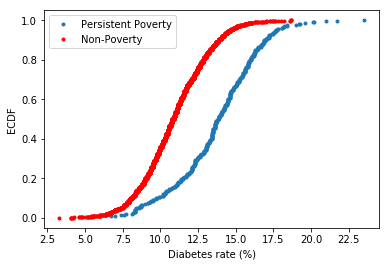

In [32]:
x_ppov, y_ppov = ecdf(ppov['PCT_DIABETES_ADULTS13'])
x_nonppov, y_nonppov = ecdf(non_ppov['PCT_DIABETES_ADULTS13'])

plt.plot(x_ppov, y_ppov,marker='.',linestyle='none',label='Persistent Poverty')
plt.plot(x_nonppov, y_nonppov,marker='.',linestyle='none', color = 'red',label='Non-Poverty')
plt.xlabel('Diabetes rate (%)')
plt.ylabel('ECDF')
plt.legend()
plt.show()

In [ ]:
# Because the size of two groups are very different, we will perform Weltch's t-test by setting equal_var=False

t2,p2 = stats.ttest_ind(ppov['PCT_DIABETES_ADULTS13'],non_ppov['PCT_DIABETES_ADULTS13'].dropna(),equal_var=False)
print('p value:',round(p2,2))

### Because p=0, we can reject our hypothesis and conclude that the diabetes rate in non-poverty counties is significantly different (smaller than) persistent poverty counties.

In [ ]:
ppov.head()

In [ ]:
plt.scatter('SODA_PRICE10','PCT_DIABETES_ADULTS13',data=ppov)

In [ ]:
# Bar chart comparing between persistent poverty counties and non-poverty counties
df3.iloc[:,3:].head()

Now we have established that non-metro counties (NMC) and persistant poverty counties (PPC) have higher diabetes rates than metro counties and non-persistant poverty counties, we are relatively certain that poverty levels and local food environments may contribute to higher diabetes rate.  
The next question is: if focusing on PPC and NMC, respectively, what factors may help to improve locals' lifestyle and alleviate diabetes rate?

In [33]:
PPC = ppov.copy() # persistant poverty counties (PPC) 
NPPC = non_ppov.copy() # Non-persistant poverty counties (NPPC) 
NMC = diabetes_nonmetro.copy() #non-metro counties (NMC)
MC = diabetes_metro.copy() # metro counties (MC)
print(PPC.shape,NMC.shape)


(353, 36) (1976, 36)


In [34]:
# How many PPC are also NMC?
print('Non metro PPC:',len(list(set(PPC.FIPS).intersection(set(NMC.FIPS)))))
print('Metro PPC:',len(list(set(PPC.FIPS).intersection(set(MC.FIPS)))))
print('Non metro NPPC:',len(list(set(NPPC.FIPS).intersection(set(NMC.FIPS)))))
print('Metro NPPC:',len(list(set(NPPC.FIPS).intersection(set(MC.FIPS)))))

Non metro PPC: 301
Metro PPC: 52
Non metro NPPC: 1675
Metro NPPC: 1115


In [35]:
a = ['PPC','PPC','NPPC','NPPC']
b = ['MC','NMC','MC','NMC']
c= [52,301,1115,1675]
foo = pd.DataFrame(dict(poverty=a, metro=b,counts=c))
foo


,poverty,metro,counts
0,PPC,MC,52
1,PPC,NMC,301
2,NPPC,MC,1115
3,NPPC,NMC,1675


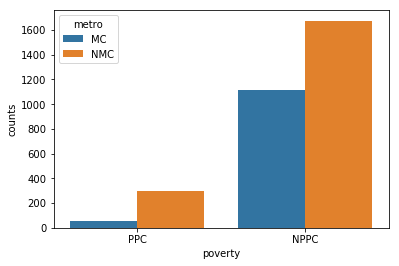

In [36]:
_ = sns.barplot(x='poverty',y='counts',hue='metro', data=foo)


In [ ]:
df3.shape